In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from utils import *

/home/chris/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Creating mock training and validation datasets

Mock data are generated by adding a sinusoidal background on top of a sinusoidal signal of a different amplitude and frequency. The time series are divided into two parts: the first part being the training set and the second beign the validation set.

In [2]:
# generate mock data
measured, noise, clean = generate_data()

# split into a training set and a validation set
indx = int(0.8*measured.shape[0])
X_train, y_train = noise[:indx], measured[:indx]
X_test, y_test = noise[indx:], measured[indx:]

# reshape network input
X_train = X_train.reshape(-1, 1, 1)
X_test = X_test.reshape(-1, 1, 1)

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (160, 1, 1)
y_train shape: (160,)
X_test shape: (40, 1, 1)
y_test shape: (40,)


Visualize training data

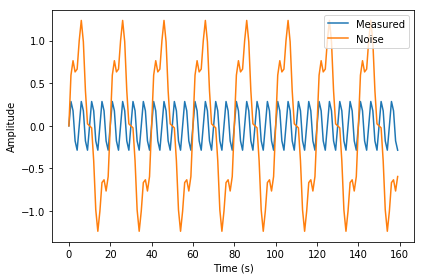

In [3]:
# plot time series
fig, ax = plt.subplots()

ax.plot(X_train[:, 0, 0], label='Measured')
ax.plot(y_train, label='Noise')
ax.set(xlabel='Time (s)', ylabel='Amplitude')
ax.legend()

fig.tight_layout()

## Training the network

Training an LSTM network to learn the noise source and subtract it from the data channel.

Create an LSTM network and visualize the architecture

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
What (LSTM)                  (None, 32)                4352      
_________________________________________________________________
Is (Dense)                   (None, 8)                 264       
_________________________________________________________________
Love (Dense)                 (None, 1)                 9         
Total params: 4,625
Trainable params: 4,625
Non-trainable params: 0
_________________________________________________________________


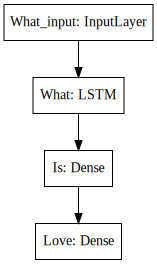

In [4]:
input_shape = X_train.shape[1:]
model = create_model(input_shape)

model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Train the LSTM network and plot training and validation losses

Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 0s 2ms/step - loss: 0.5480 - val_loss: 0.5460
Epoch 2/20
160/160 [==============================] - 0s 109us/step - loss: 0.5471 - val_loss: 0.5451
Epoch 3/20
160/160 [==============================] - 0s 73us/step - loss: 0.5458 - val_loss: 0.5449
Epoch 4/20
160/160 [==============================] - 0s 172us/step - loss: 0.5450 - val_loss: 0.5445
Epoch 5/20
160/160 [==============================] - 0s 140us/step - loss: 0.5446 - val_loss: 0.5440
Epoch 6/20
160/160 [==============================] - 0s 97us/step - loss: 0.5452 - val_loss: 0.5438
Epoch 7/20
160/160 [==============================] - 0s 145us/step - loss: 0.5437 - val_loss: 0.5434
Epoch 8/20
160/160 [==============================] - 0s 86us/step - loss: 0.5436 - val_loss: 0.5429
Epoch 9/20
160/160 [==============================] - 0s 137us/step - loss: 0.5430 - val_loss: 0.5426
Epoch 10/20
160/160 [=====================

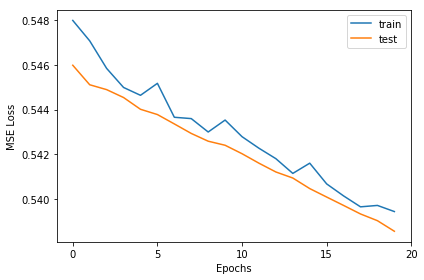

In [5]:
# Plot train loss and val loss
stats = model.fit(X_train, y_train, 
                  validation_data = (X_test, y_test),
                  epochs=20, batch_size=32)

fig, ax = plt.subplots()

ax.plot(stats.history['loss'], label='train')
ax.plot(stats.history['val_loss'], label='test')
ax.set(xlabel='Epochs', ylabel='MSE Loss', xticks=np.arange(0, 21, 5))
ax.legend()

fig.tight_layout()

## Results

The trained network predict and subtract the noise source. Calculate the RMSE

RMSE: 0.19632732217681909


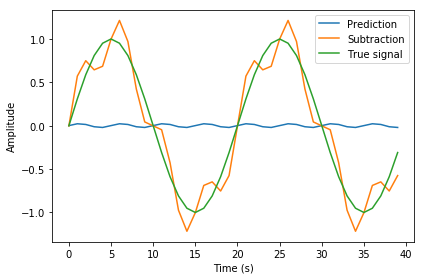

In [6]:
y_pred = model.predict(X_test)
y_pred = np.squeeze(y_pred)
y_clean = y_test-y_pred

print('RMSE: {}'.format(np.sqrt(np.mean((y_clean-clean[indx:])**2))))

fig, ax = plt.subplots()

ax.plot(y_pred, label='Prediction')
ax.plot(y_clean, label='Subtraction')
ax.plot(clean[indx:], label='True signal')
ax.set(xlabel='Time (s)', ylabel='Amplitude')
ax.legend()

fig.tight_layout()

## Hyperparameter Optimization

Apply hyperparameter optimization using Hyperopt Tree-structured Parzen Estimators (TPE) and try to get a better RMSE

In [7]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [8]:
# define a search space
space = {
    'activation':hp.choice('activation', ('relu', 'tanh')),
    'lr':hp.loguniform('lr', np.log(1e-6), np.log(1e-2)), 
    'dropout':hp.uniform('dropout', 0.0, 1.0), 
    'reg':hp.uniform('reg', 1e-6, 1e-3)
}

# define loss function
def loss(params):
    
    input_shape = X_train.shape[1:]
    model = create_model(input_shape, **params)

    _ = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)
    val_loss = model.evaluate(X_test, y_test, verbose=1)
    print('Loss: {}'.format(val_loss))
    
    return {'loss':val_loss, 'status':STATUS_OK}

In [9]:
print('Begin tuning')
print('------------')
trials = Trials()
best_params = fmin(loss,
                   space = space,
                   algo = tpe.suggest,
                   max_evals = 20,
                   trials = trials)
print('')
print('Best parameters:')
print('----------------')
best_params['activation'] = ['relu', 'tanh'][best_params['activation']]
for k, v in best_params.items():
    print('{} = {}'.format(k, v))

Begin tuning
------------
40/40 [==============================] - 0s 2ms/step
Loss: 0.5786983609199524
40/40 [==============================] - 0s 3ms/step
Loss: 1.102782917022705
40/40 [==============================] - 0s 4ms/step
Loss: 0.7187470674514771
40/40 [==============================] - 0s 4ms/step
Loss: 0.5550930500030518
40/40 [==============================] - 0s 5ms/step
Loss: 0.5837780833244324
40/40 [==============================] - 0s 6ms/step
Loss: 0.5605306148529052
40/40 [==============================] - 0s 7ms/step
Loss: 0.561450469493866
40/40 [==============================] - 0s 7ms/step
Loss: 0.5772148251533509
40/40 [==============================] - 0s 8ms/step
Loss: 0.6679161489009857
40/40 [==============================] - 0s 9ms/step
Loss: 0.5729451656341553
40/40 [==============================] - 0s 10ms/step
Loss: 0.9338226348161698
40/40 [==============================] - 0s 10ms/step
Loss: 0.6787738800048828
40/40 [==============================]

Train the network using the best hyperparameters

Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 2s 12ms/step - loss: 0.5562 - val_loss: 0.5429
Epoch 2/20
160/160 [==============================] - 0s 101us/step - loss: 0.5444 - val_loss: 0.5471
Epoch 3/20
160/160 [==============================] - 0s 107us/step - loss: 0.5513 - val_loss: 0.5434
Epoch 4/20
160/160 [==============================] - 0s 154us/step - loss: 0.5431 - val_loss: 0.5363
Epoch 5/20
160/160 [==============================] - 0s 196us/step - loss: 0.5331 - val_loss: 0.5341
Epoch 6/20
160/160 [==============================] - 0s 150us/step - loss: 0.5380 - val_loss: 0.5327
Epoch 7/20
160/160 [==============================] - 0s 128us/step - loss: 0.5314 - val_loss: 0.5323
Epoch 8/20
160/160 [==============================] - 0s 150us/step - loss: 0.5312 - val_loss: 0.5285
Epoch 9/20
160/160 [==============================] - 0s 158us/step - loss: 0.5402 - val_loss: 0.5273
Epoch 10/20
160/160 [=================

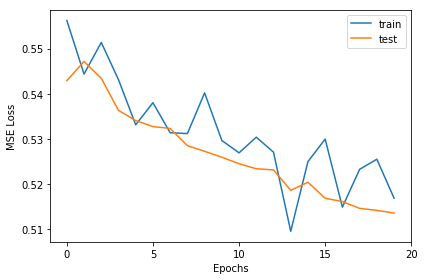

In [10]:
input_shape = X_train.shape[1:]
model = create_model(input_shape, **best_params)


# Plot train loss and val loss
stats = model.fit(X_train, y_train, 
                  validation_data = (X_test, y_test),
                  epochs=20, batch_size=32)

fig, ax = plt.subplots()

ax.plot(stats.history['loss'], label='train')
ax.plot(stats.history['val_loss'], label='test')
ax.set(xlabel='Epochs', ylabel='MSE Loss', xticks=np.arange(0, 21, 5))
ax.legend()

fig.tight_layout()

## Results after tuning

Plot subtraction after tuning and calculate the RMSE. We see that the performance post-tuning improves greatly.

RMSE: 0.0760254564312577


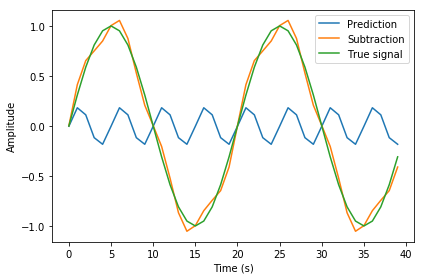

In [11]:
y_pred = model.predict(X_test)
y_pred = np.squeeze(y_pred)
y_clean = y_test-y_pred

print('RMSE: {}'.format(np.sqrt(np.mean((y_clean-clean[indx:])**2))))

fig, ax = plt.subplots()

ax.plot(y_pred, label='Prediction')
ax.plot(y_clean, label='Subtraction')
ax.plot(clean[indx:], label='True signal')
ax.set(xlabel='Time (s)', ylabel='Amplitude')
ax.legend()

fig.tight_layout()